# Loading libraries

In [1]:
import sys
import os
import yaml
import pandas as pd
import numpy as np
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
import optuna

from darts import models
from darts import metrics
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

from statsforecast.models import AutoARIMA

from data_formatter.base import *
from bin.utils import *

# Processing raw data and adding covariates

In [3]:
filenames = []
for root, dir, files in os.walk('raw_data/Colas2019'):
  for file in files:
    if '.csv' in file:
      filenames.append(os.path.join(root, file))
      
# next we loop through each file
nfiles = len(files)

count = 0
for file in filenames:
  # read in data and extract id from filename
  curr = pd.read_csv(file)
  curr['id'] = int(file.split()[1].split(".")[0])
  # select desired columns, rename, and drop nas
  curr = curr[['id', 'hora', 'glucemia']]
  curr.rename(columns = {'hora': 'time', 'glucemia': 'gl'}, inplace=True)
  curr.dropna(inplace=True)

  # calculate time (only given in hms) as follows:
  # (1) get the time per day in seconds, (2) get the time differences, and correct for the day crossove (< 0)
  # (3) take the cumulative sum and add the cumulative number of seconds from start to the base date
  # thus the hms are real, while the year, month, day are fake
  time_secs = []
  for i in curr['time']:
      time_secs.append(int(i.split(":")[0])*60*60 + int(i.split(":")[1])*60 + int(i.split(":")[2])*1)
  time_diff = np.diff(np.array(time_secs)).tolist()
  time_diff_adj = [x if x > 0 else 24*60*60 + x for x in time_diff]
  time_diff_adj.insert(0, 0)
  cumin = np.cumsum(time_diff_adj)
  datetime = pd.to_datetime('2012-01-01') + pd.to_timedelta(cumin, unit='sec')
  curr['time'] = datetime
  curr['id'] = curr['id'].astype('int')
  curr.reset_index(drop=True, inplace=True)

  if count == 0:
    df = curr
    count += 1
  else:
    df = pd.concat([df, curr])

In [90]:
# join with covariates
covariates = pd.read_csv('raw_data/Colas2019/clinical_data.txt', sep = " ")
covariates['id'] = covariates.index

combined = pd.merge(
    df, covariates, how = "left"
)

# define NA fill values for covariates
values = {
    'gender': 2, # if gender is NA, create own category
    'age': combined['age'].mean(),
    'BMI': combined['BMI'].mean(),
    'glycaemia': combined['glycaemia'].mean(),
    'HbA1c': combined['HbA1c'].mean(),
    'follow.up': combined['follow.up'].mean(),
    'T2DM': False
}
combined = combined.fillna(value = values)

# write to csv
combined.to_csv('raw_data/colas.csv')

# Check statistics of the data

In [2]:
import matplotlib.pyplot as plt

# load yaml config file
with open('./config/colas.yaml', 'r') as f:
    config = yaml.safe_load(f)

# set interpolation params for no interpolation
new_config = config.copy()
new_config['interpolation_params']['gap_threshold'] = 5
new_config['interpolation_params']['min_drop_length'] = 0
# set split params for no splitting
new_config['split_params']['test_percent_subjects'] = 0
new_config['split_params']['length_segment'] = 0
# set scaling params for no scaling
new_config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(new_config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...


c:\Users\L Chun\Documents\Tamu\CGM_project\GitHub\GluNet\data_formatter\base.py:51: DtypeWarning: Columns (4,5,6,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(self.params['data_csv_path'], index_col=self.params['index_col'], na_filter=False)


Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 0
	Extracted segments: 283
	Interpolated values: 4
	Percent of values interpolated: 0.00%
Splitting data...
	Train: 114247 (100.00%)
	Val: 0 (0.00%)
	Test: 0 (0.00%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


Train segment lengths:
	Min:  1
	Max:  576
	1st Quartile:  140.5
	Median:  576.0
	Mean:  403.69964664310953
	Std:  223.33792449061625


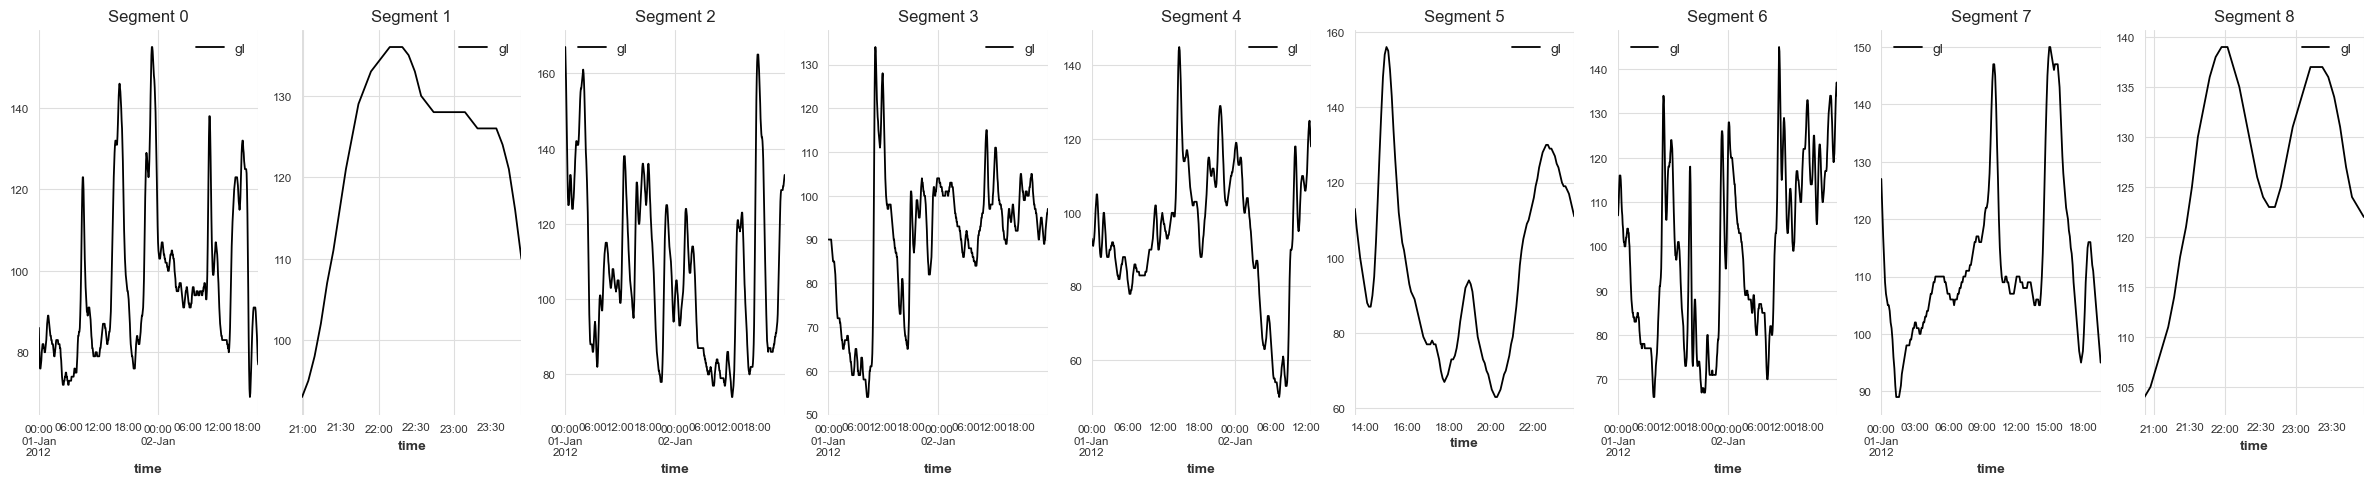

In [3]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\t1st Quartile: ', np.quantile(segment_lens, 0.25))
print('\tMedian: ', np.median(segment_lens))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# plot first 9 segments
num_segments = 9
plot_data = formatter.train_data

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data.plot(x='time', y='gl', ax=axs[i], title='Segment {}'.format(group))
    if i >= num_segments - 1:
        break

Segment 1 is too short
Segment 5 is too short
Segment 7 is too short
Segment 8 is too short
Segment 9 is too short
Segment 10 is too short
Segment 13 is too short


ValueError: Cannot take a larger sample than population when 'replace=False'

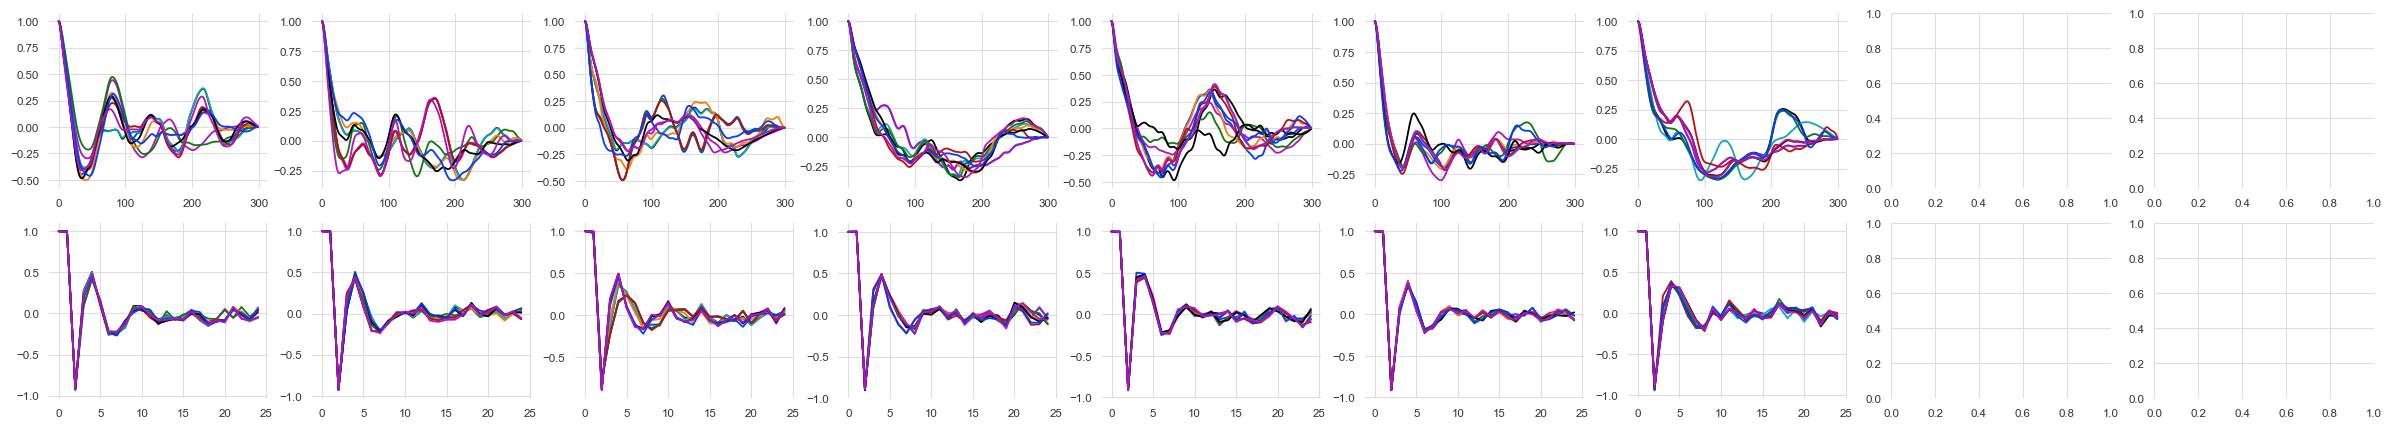

In [4]:
# plot acf of random samples from first 9 segments segments
fig, ax = plt.subplots(2, num_segments, figsize=(30, 5))
lags = 300; k = 0
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    else:
        # select 10 random samples from index of data
        sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
        # plot acf / pacf of each sample
        for j in sample:
            acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
            pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
            ax[0, k].plot(acf)
            ax[1, k].plot(pacf)
        k += 1
        if k >= num_segments:
            break

# Change the config according to the observations above

In [5]:
# set interpolation params for interpolation
new_config['interpolation_params']['gap_threshold'] = 45 # minutes - use as in config file 
new_config['interpolation_params']['min_drop_length'] = 192

formatter = DataFormatter(new_config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...


c:\Users\L Chun\Documents\Tamu\CGM_project\GitHub\GluNet\data_formatter\base.py:51: DtypeWarning: Columns (4,5,6,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(self.params['data_csv_path'], index_col=self.params['index_col'], na_filter=False)


Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 63
	Extracted segments: 205
	Interpolated values: 241
	Percent of values interpolated: 0.22%
Splitting data...
	Train: 108811 (100.00%)
	Val: 0 (0.00%)
	Test: 0 (0.00%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


Train segment lengths:
	Min:  224
	Max:  576
	1st Quartile:  576.0
	Median:  576.0
	3rd Quartile:  576.0
	Mean:  530.7853658536585
	Std:  100.56616693591948


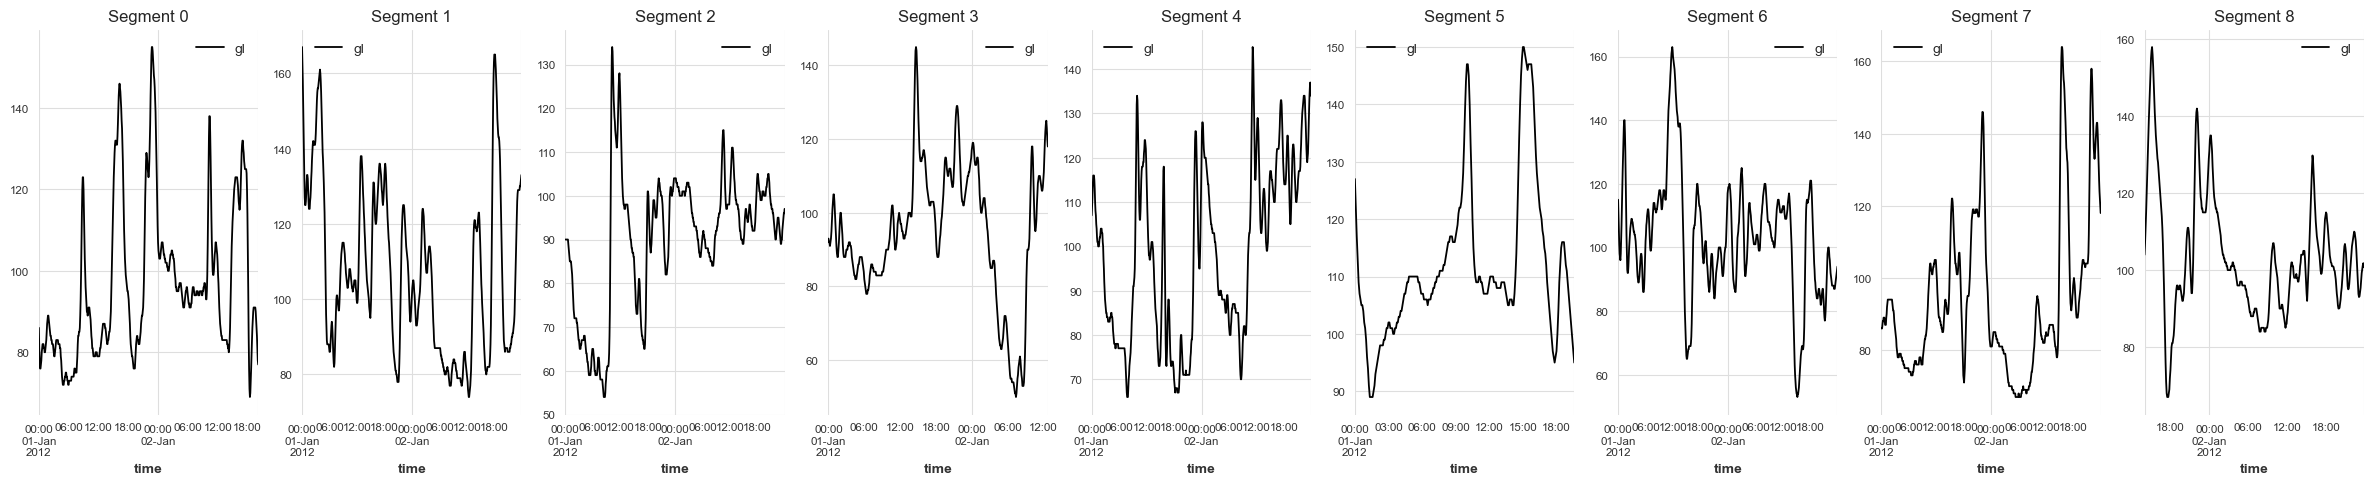

In [6]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\t1st Quartile: ', np.quantile(segment_lens, 0.25))
print('\tMedian: ', np.median(segment_lens))
print('\t3rd Quartile: ', np.quantile(segment_lens, 0.75))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# plot first 9 segments
num_segments = 9
plot_data = formatter.train_data

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data.plot(x='time', y='gl', ax=axs[i], title='Segment {}'.format(group))
    if i >= num_segments - 1:
        break

Segment 5 is too short


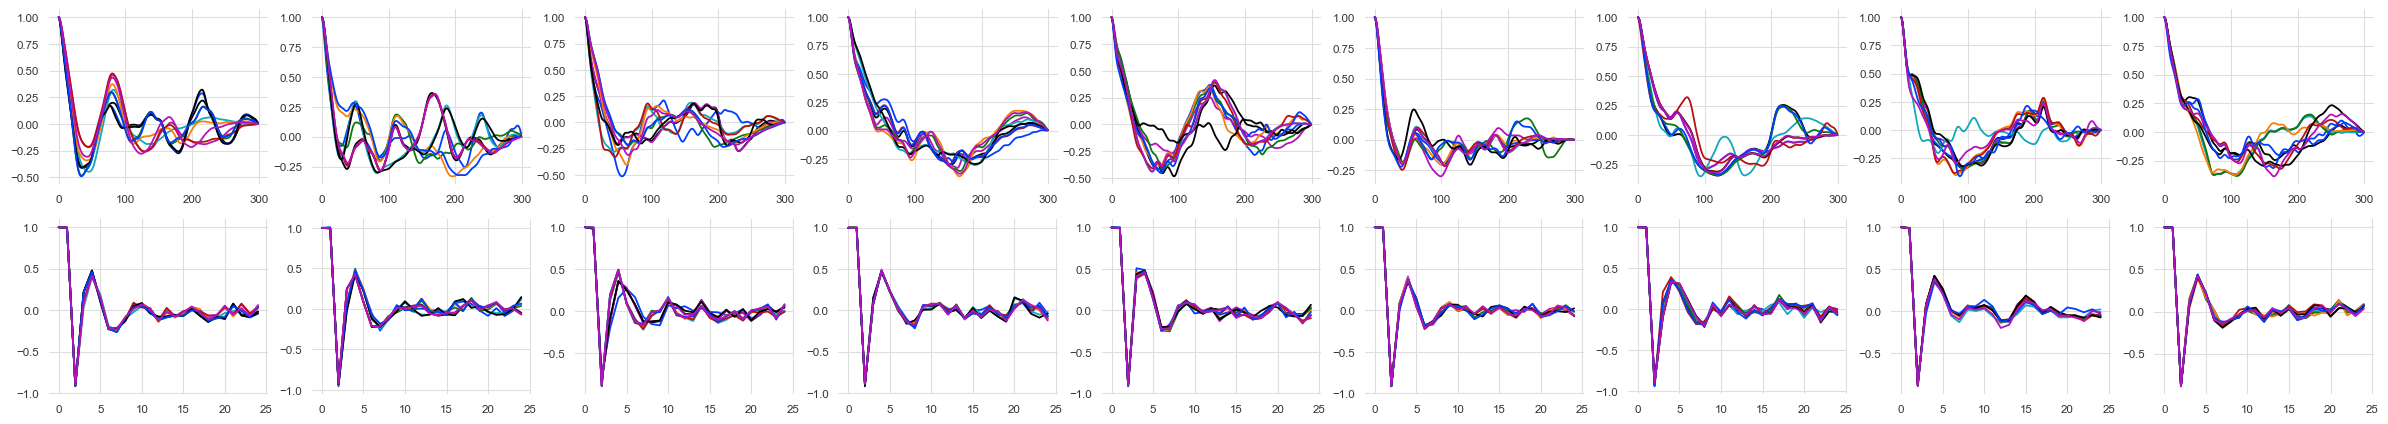

In [7]:
# plot acf of random samples from first 9 segments segments
fig, ax = plt.subplots(2, num_segments, figsize=(30, 5))
lags = 300; k = 0
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    else:
        # select 10 random samples from index of data
        sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
        # plot acf / pacf of each sample
        for j in sample:
            acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
            pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
            ax[0, k].plot(acf)
            ax[1, k].plot(pacf)
        k += 1
        if k >= num_segments:
            break

In [8]:
with open('./config/colas.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
# set interpolation params for no interpolation
config['interpolation_params']['gap_threshold'] = 45
config['interpolation_params']['min_drop_length'] = 192
# set split params for no splitting
config['split_params']['test_percent_subjects'] = 0.1
config['split_params']['length_segment'] = 192
# set scaling params for no scaling
config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...


c:\Users\L Chun\Documents\Tamu\CGM_project\GitHub\GluNet\data_formatter\base.py:51: DtypeWarning: Columns (4,5,6,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(self.params['data_csv_path'], index_col=self.params['index_col'], na_filter=False)


Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 63
	Extracted segments: 205
	Interpolated values: 241
	Percent of values interpolated: 0.22%
Splitting data...
	Train: 37857 (38.80%)
	Val: 31296 (32.08%)
	Test: 39658 (40.65%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


# Models (no covariates)

## Convert data and (optional) scaling

In [9]:
def load_data(seed = 0, study_file = None):
    # load data
    with open('./config/colas.yaml', 'r') as f:
        config = yaml.safe_load(f)
    config['split_params']['random_state'] = seed
    formatter = DataFormatter(config, study_file = study_file)

    # convert to series
    time_col = formatter.get_column('time')
    group_col = formatter.get_column('sid')
    target_col = formatter.get_column('target')
    static_cols = formatter.get_column('static_covs')
    static_cols = static_cols + [formatter.get_column('id')] if static_cols is not None else [formatter.get_column('id')]
    dynamic_cols = formatter.get_column('dynamic_covs')
    future_cols = formatter.get_column('future_covs')

    # build series
    series, scalers = make_series({'train': formatter.train_data,
                                    'val': formatter.val_data,
                                    'test': formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)],
                                    'test_ood': formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]},
                                    time_col,
                                    group_col,
                                    {'target': target_col,
                                    'static': static_cols,
                                    'dynamic': dynamic_cols,
                                    'future': future_cols})
    
    return formatter, series, scalers

formatter, series, scalers = load_data()

--------------------------------
Loading column definition...
Checking column definition...
Loading data...


c:\Users\L Chun\Documents\Tamu\CGM_project\GitHub\GluNet\data_formatter\base.py:51: DtypeWarning: Columns (4,5,6,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(self.params['data_csv_path'], index_col=self.params['index_col'], na_filter=False)


Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 63
	Extracted segments: 205
	Interpolated values: 241
	Percent of values interpolated: 0.22%
Splitting data...
	Train: 37857 (38.80%)
	Val: 31296 (32.08%)
	Test: 39658 (40.65%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


In [10]:
for f in series['train']['target']:
    f.plot(label='train', alpha=0.1, color='grey')
series['test_ood']['target'][0].plot(label='test_ood')
for f in series['test']['target']:
    f.plot(label='test_id', color='orange', alpha=0.5)

In [ ]:
# plot 18h segments that start at 6AM
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i in range(3):
    for j in range(3):
        serie = series['train']['target'][i+3*j]
        start = None
        for k, hour in enumerate(serie.time_index.hour):
            if hour == 6:
                start = k
                break
        if start is not None and start + 216 <= len(serie):
            serie = serie[start:(start+216)]
            serie.plot(ax=axs[i, j], label='Segment {}'.format(i+3*j))

In [ ]:
# plot 18h segments that start at 6AM
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i in range(3):
    for j in range(3):
        serie = series['train']['target'][i+3*j]
        start = None
        for k, hour in enumerate(serie.time_index.hour):
            if hour == 6:
                start = k
                break
        if start is not None and start + 216 <= len(serie):
            serie = serie[start:(start+216)]
            # rescale
            serie = scalers['target'].inverse_transform(serie)
            # set y-axis limits for axs[i, j]
            serie.plot(ax=axs[i, j], label='Segment {}'.format(i+3*j))
            axs[i, j].set_ylim(0, 420)

## ARIMA

In [12]:
def test_model(test_data, scaler, in_len, out_len, stride, target_col, group_col):
    errors = []
    for group, data in test_data.groupby(group_col):
        train_set = data[target_col].iloc[:in_len].values.flatten()
        # fit model
        model = AutoARIMA(start_p = 0,
                        max_p = 10,
                        start_q = 0,
                        max_q = 10,
                        start_P = 0,
                        max_P = 10,
                        start_Q=0,
                        max_Q=10,
                        allowdrift=True,
                        allowmean=True,
                        parallel=False)
        model.fit(train_set)
        # get valid sampling locations for future prediction
        start_idx = np.arange(start=stride, stop=len(data) - in_len - out_len + 1, step=stride)
        end_idx = start_idx + in_len
        # iterate and collect predictions
        for i in range(len(start_idx)):
            input = data[target_col].iloc[start_idx[i]:end_idx[i]].values.flatten()
            true = data[target_col].iloc[end_idx[i]:(end_idx[i]+out_len)].values.flatten()
            prediction = model.forward(input, h=out_len)['mean']
            # unscale true and prediction
            true = scaler.inverse_transform(true.reshape(-1, 1)).flatten()
            prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()
            # collect errors
            errors.append(np.array([np.mean((true - prediction)**2), np.mean(np.abs(true - prediction))]))
    errors = np.vstack(errors)
    return errors

In [13]:
# load data
with open('./config/colas.yaml', 'r') as f:
        config = yaml.safe_load(f)
config['split_params']['random_state'] = 0
config['scaling_params']['scaler'] = 'StandardScaler'
formatter = DataFormatter(config, study_file = None)

# set params
in_len = formatter.params['max_length_input']
out_len = formatter.params['length_pred']
stride = formatter.params['length_pred'] // 2
target_col = formatter.get_column('target')
group_col = formatter.get_column('sid')

--------------------------------
Loading column definition...
Checking column definition...
Loading data...


c:\Users\L Chun\Documents\Tamu\CGM_project\GitHub\GluNet\data_formatter\base.py:51: DtypeWarning: Columns (4,5,6,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(self.params['data_csv_path'], index_col=self.params['index_col'], na_filter=False)


Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 63
	Extracted segments: 205
	Interpolated values: 241
	Percent of values interpolated: 0.22%
Splitting data...
	Train: 37857 (38.80%)
	Val: 31296 (32.08%)
	Test: 39658 (40.65%)
Scaling data...
	Scaled columns: ['id', 'gl', 'time_year', 'time_month', 'time_day', 'time_hour', 'time_minute']
Data formatting complete.
--------------------------------


In [14]:
test_data = formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)]
test_data_ood = formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]

# backtest on the ID test set
id_errors_sample = test_model(test_data, formatter.scalers[target_col[0]], in_len, out_len, stride, target_col, group_col)
id_errors_sample = np.vstack(id_errors_sample)
id_error_stats_sample = compute_error_statistics(id_errors_sample)

# backtest on the ood test set
ood_errors_sample = test_model(test_data_ood, formatter.scalers[target_col[0]], in_len, out_len, stride, target_col, group_col)
ood_errors_sample = np.vstack(ood_errors_sample)
ood_errors_stats_sample = compute_error_statistics(ood_errors_sample)

c:\ProgramData\Anaconda3\lib\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, par[narma + np.arange(ncxreg)])
c:\ProgramData\Anaconda3\lib\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, par[narma + np.arange(ncxreg)])
c:\ProgramData\Anaconda3\lib\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, par[narma + np.arange(ncxreg)])
c:\ProgramData\Anaconda3\lib\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, par[narma + np.arange(ncxreg)])
c:\ProgramData\Anaconda3\lib\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, par[narma + np.arange(ncxreg)])
c:\ProgramData\Anaconda3\lib\site-packages\statsforecast\arima.py:680: RuntimeWarning: overflow encountered in subtract
  x -= np.dot(xreg, 

## Linear Regression

In [15]:
model = models.LinearRegressionModel(lags = 32,
                                     output_chunk_length = formatter.params['length_pred'])

model.fit(series['train']['target'],
          max_samples_per_ts=None, 
          )

In [16]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])
id_errors_sample = rescale_and_backtest(series['test']['target'],
                                    forecasts,  
                                    [metrics.mse, metrics.mae],
                                    scalers['target'],
                                    reduction=None)
id_errors_sample = np.vstack(id_errors_sample)
np.median(id_errors_sample, axis=0)

  0%|          | 0/148 [00:00<?, ?it/s]

array([35.593548,  5.03846 ], dtype=float32)

In [ ]:
forecasts = model.historical_forecasts(series['test_ood']['target'],
                                                forecast_horizon=formatter.params['length_pred'], 
                                                stride=formatter.params['length_pred'] // 2,
                                                retrain=False,
                                                verbose=True,
                                                last_points_only=False,
                                                start=formatter.params["max_length_input"])
ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
target_ts = scalers['target'].inverse_transform(series['test_ood']['target'][0])
predicted_ts = [scalers['target'].inverse_transform(f) for f in forecasts]

errors = [
    [metric_f(target_ts, f) for metric_f in [metrics.mse, metrics.mae]]
    for f in predicted_ts
    if f.time_index.hour[0] > 6
]

errors = np.array(errors)
errors.shape

np.median(errors, axis=0)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['val']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

## XGBoost

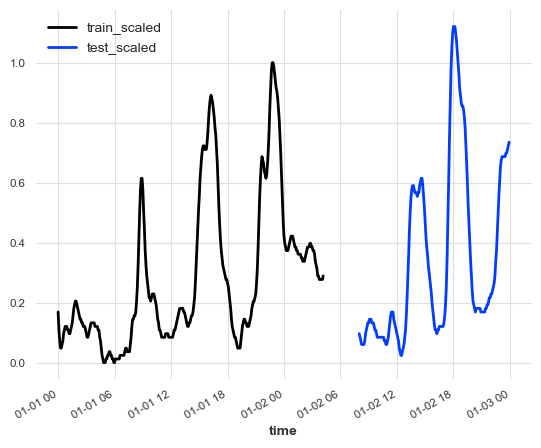

In [9]:
model = models.XGBModel(lags=96, 
                        learning_rate=0.773,
                        subsample=0.8,
                        min_child_weight=1.0,
                        colsample_bytree=1.0,
                        max_depth=6,
                        gamma=0.5,
                        reg_alpha=0.167,
                        reg_lambda=0.229,
                        n_estimators=352,
                        model_seed=0)

model.fit(series['train']['target'],
          max_samples_per_ts=None, 
          )

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])
id_errors_sample = rescale_and_backtest(series['test']['target'],
                                    forecasts,  
                                    [metrics.mse, metrics.mae],
                                    scalers['target'],
                                    reduction=None)
id_errors_sample = np.vstack(id_errors_sample)
np.median(id_errors_sample, axis=0)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
hours = []
for i in range(len(series['test']['target'])):
    hours += list(series['test']['target'][i].time_index[formatter.params['max_length_input']: ].hour)
axs[0].hist(hours, bins=36)

hours = []
for i in range(len(series['test_ood']['target'])):
    hours += list(series['test_ood']['target'][i].time_index[formatter.params['max_length_input']: ].hour)
axs[1].hist(hours, bins=36)

In [ ]:
forecasts = model.historical_forecasts(series['test_ood']['target'],
                                                forecast_horizon=formatter.params['length_pred'], 
                                                stride=formatter.params['length_pred'] // 2,
                                                retrain=False,
                                                verbose=True,
                                                last_points_only=False,
                                                start=formatter.params["max_length_input"])
ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
def rescale_and_backtest(series: Union[TimeSeries, Sequence[TimeSeries]],
                         forecasts: Union[TimeSeries, Sequence[TimeSeries]], 
                         metric: Union[
                                    Callable[[TimeSeries, TimeSeries], float],
                                    List[Callable[[TimeSeries, TimeSeries], float]],
                                ], 
                         scaler: Callable[[TimeSeries], TimeSeries] = None,
                         reduction: Union[Callable[[np.ndarray], float], None] = np.mean,
                        ):
    """
    Backtest the forecasts on the series.

    Parameters
    ----------
    series
        The target time series.
    forecasts
        The forecasts.
    scaler
        The scaler used to scale the series.
    metric
        The metric to use for backtesting.
    reduction
        The reduction to apply to the metric.

    Returns
    -------
    float or List[float] or List[List[float]]
        The (sequence of) error score on a series, or list of list containing error scores for each
        provided series and each sample.
    """
    series = [series] if isinstance(series, TimeSeries) else series
    if len(series) == 1:
        forecasts = [forecasts]
    if not isinstance(metric, list):
        metric = [metric]

    # reverse scaling, forecasts and true values, compute errors
    backtest_list = []
    for idx, target_ts in enumerate(series):
        if scaler is not None:
            target_ts = scaler.inverse_transform(target_ts)
            predicted_ts = [scaler.inverse_transform(f) for f in forecasts[idx]]
        errors = [
            [metric_f(target_ts, f) for metric_f in metric]
            if len(metric) > 1
            else metric[0](target_ts, f)
            for f in predicted_ts
            if f.time_index.hour[0] > 6 and f.time_index.hour[0] < 18
        ]
        if reduction is None:
            backtest_list.append(np.array(errors))
        else:
            backtest_list.append(reduction(np.array(errors), axis=0))
    return backtest_list if len(backtest_list) > 1 else backtest_list[0]

ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        true = scalers['target'].inverse_transform(series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36))
        forecast = scalers['target'].inverse_transform(f)
        forecast.plot(ax=axs[j, i], label='forecast')
        true.plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j in range(5):
        forecast = scalers['target'].inverse_transform(forecasts[i+6*j])
        true = scalers['target'].inverse_transform(series['test_ood']['target'][0].slice_n_points_after(forecast.time_index[0] - pd.Timedelta("2h"), 36))
        forecast.plot(ax=axs[j, i], label='forecast')
        true.plot(ax=axs[j, i], label='true')

## TFT

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_name = f'tensorboard_tft_weinstock'
work_dir = './output'
el_stopper = EarlyStopping(
                            monitor="val_loss",
                            patience=20,
                            min_delta=0.001,
                            mode='min',
                            )
loss_logger = LossLogger()
pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0], "callbacks": [el_stopper, loss_logger]}

# build the TFTModel model
model = models.TFTModel(input_chunk_length = 96, 
                        output_chunk_length = formatter.params['length_pred'], 
                        hidden_size = 64,
                        lstm_layers = 1,
                        num_attention_heads = 4,
                        full_attention = True,
                        dropout = 0.1,
                        hidden_continuous_size = 16,
                        add_relative_index = True,
                        model_name = model_name,
                        work_dir = work_dir,
                        log_tensorboard = True,
                        pl_trainer_kwargs = pl_trainer_kwargs,
                        batch_size = 64,
                        optimizer_kwargs = {'lr': 0.001},
                        save_checkpoints = True,
                        force_reset=True)

In [ ]:
model.fit(series=series['train']['target'],
              val_series=series['val']['target'],
              max_samples_per_ts=200,
              verbose=True,)

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=False,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])

In [ ]:
errors = rescale_and_backtest(series['test']['target'],
                                      forecasts,  
                                      [metrics.mse, metrics.mae],
                                      scalers['target'],
                                      reduction=None)
errors = np.vstack(errors)         
np.median(errors, axis=0)                             

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

## NHiTS

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_name = f'tensorboard_nhits_weinstock'
work_dir = './output'
el_stopper = EarlyStopping(monitor="val_loss", patience=20, min_delta=0.001, mode='min')
loss_logger = LossLogger()
pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0], "callbacks": [el_stopper, loss_logger]}

# build the TFTModel model
model = models.NHiTSModel(input_chunk_length=96, 
                            output_chunk_length=12, 
                            num_stacks=3, 
                            num_blocks=1, 
                            num_layers=2, 
                            layer_widths=512,  
                            n_freq_downsample=None, 
                            dropout=0.05, 
                            activation='ReLU',
                            log_tensorboard = True,
                            pl_trainer_kwargs = pl_trainer_kwargs,
                            batch_size = 64,
                            optimizer_kwargs = {'lr': 0.001},
                            save_checkpoints = True,
                            model_name = model_name,
                            work_dir = work_dir,
                            force_reset=True)

In [ ]:
model.fit(series=series['train']['target'],
              val_series=series['val']['target'],
              max_samples_per_ts=200,
              verbose=True,)

In [ ]:
model.load_from_checkpoint(model_name, work_dir = work_dir)

forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=False,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])

errors = rescale_and_backtest(series['test']['target'],
                                      forecasts,  
                                      [metrics.mse, metrics.mae],
                                      scalers['target'],
                                      reduction=None)
errors = np.vstack(errors)         
np.median(errors, axis=0)                             

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

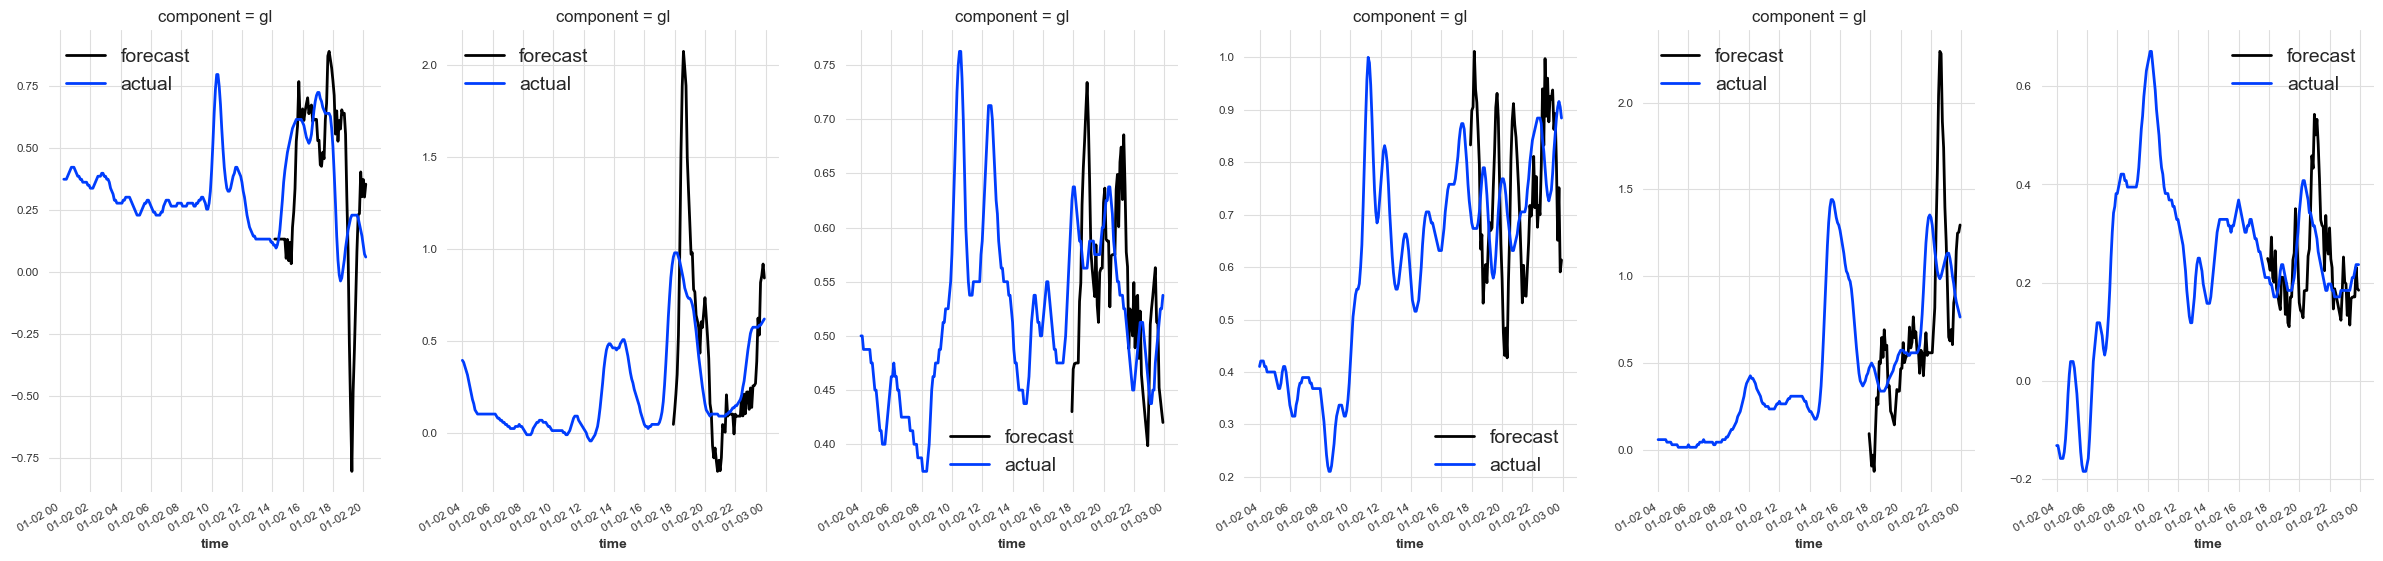

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

## Transformer

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_name = f'tensorboard_transformer_weinstock'
work_dir = './output'
el_stopper = EarlyStopping(monitor="val_loss", patience=20, min_delta=0.001, mode='min')
loss_logger = LossLogger()
pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0], "callbacks": [el_stopper, loss_logger]}

# build the TFTModel model
model = models.TransformerModel(input_chunk_length=96, 
                            output_chunk_length=12, 
                            d_model=64, 
                            nhead=4, 
                            num_encoder_layers=3, 
                            num_decoder_layers=3, 
                            dim_feedforward=512, 
                            dropout=0.1,
                            log_tensorboard = True,
                            pl_trainer_kwargs = pl_trainer_kwargs,
                            batch_size = 64,
                            optimizer_kwargs = {'lr': 0.001},
                            save_checkpoints = True,
                            model_name = model_name,
                            work_dir = work_dir,)

[I 2023-01-31 22:21:28,716] A new study created in memory with name: no-name-2bb8557f-ae39-4bb1-b2ed-36502928a5ad
[I 2023-02-01 01:07:12,345] Trial 0 finished with value: 0.3875742447629338 and parameters: {'in_len': 105, 'p': 2, 'd': 3, 'q': 1}. Best is trial 0 with value: 0.3875742447629338.


Current value: 0.3875742447629338, Current params: {'in_len': 105, 'p': 2, 'd': 3, 'q': 1}
Best value: 0.3875742447629338, Best params: {'in_len': 105, 'p': 2, 'd': 3, 'q': 1}


In [ ]:
model.fit(series=series['train']['target'],
              val_series=series['val']['target'],
              max_samples_per_ts=200,
              verbose=True,)

In [ ]:
model.load_from_checkpoint(model_name, work_dir = work_dir)

forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=False,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])

errors = rescale_and_backtest(series['test']['target'],
                                      forecasts,  
                                      [metrics.mse, metrics.mae],
                                      scalers['target'],
                                      reduction=None)
errors = np.vstack(errors)         
np.median(errors, axis=0)                             

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

# Model (with covariates)

## Convert data and optional scaling

In [2]:
def load_data(seed = 0, study_file = None):
    # load data
    with open('./config/colas.yaml', 'r') as f:
        config = yaml.safe_load(f)
    config['split_params']['random_state'] = seed
    formatter = DataFormatter(config, study_file = study_file)

    # convert to series
    time_col = formatter.get_column('time')
    group_col = formatter.get_column('sid')
    target_col = formatter.get_column('target')
    static_cols = formatter.get_column('static_covs')
    static_cols = static_cols + [formatter.get_column('id')] if static_cols is not None else [formatter.get_column('id')]
    dynamic_cols = formatter.get_column('dynamic_covs')
    future_cols = formatter.get_column('future_covs')

    # build series
    series, scalers = make_series({'train': formatter.train_data,
                                    'val': formatter.val_data,
                                    'test': formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)],
                                    'test_ood': formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]},
                                    time_col,
                                    group_col,
                                    {'target': target_col,
                                    'static': static_cols,
                                    'dynamic': dynamic_cols,
                                    'future': future_cols})
    
    return formatter, series, scalers

formatter, series, scalers = load_data()

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Dropping columns / rows...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		gender: REAL_VALUED (STATIC_INPUT)
		age: REAL_VALUED (STATIC_INPUT)
		BMI: REAL_VALUED (STATIC_INPUT)
		glycaemia: REAL_VALUED (STATIC_INPUT)
		HbA1c: REAL_VALUED (STATIC_INPUT)
		follow.up: REAL_VALUED (STATIC_INPUT)
		T2DM: REAL_VALUED (STATIC_INPUT)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 63
	Extracted segments: 205
	Interpolated values: 241
	Percent of values interpolated: 0.22%
Splitting data...
	Train: 72275 (45.89%)
	Val: 35713 (22.68%)
	Test: 38253 (24.29%)
	Tes

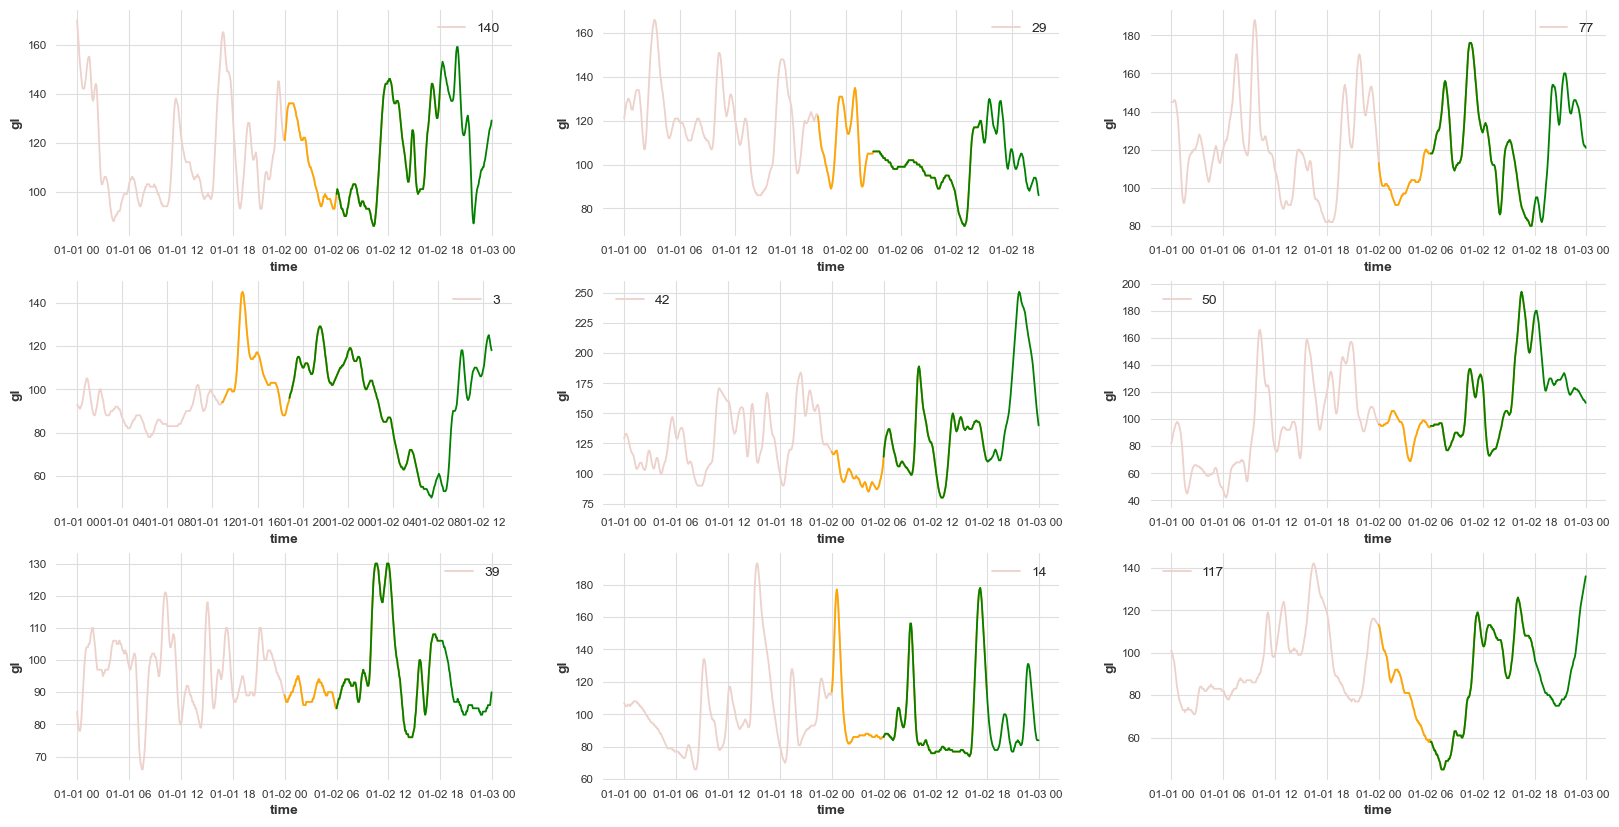

In [3]:
id = formatter.get_column('id')
time = formatter.get_column('time')
target = formatter.get_column('target')[0]
sid = formatter.get_column('sid')
# plot for 9 random ids
ids = np.random.choice(np.unique(formatter.train_data[id]), 9)
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for j, i in enumerate(ids):
    train_data = formatter.train_data[formatter.train_data[id] == i]
    val_data = None; test_data = None
    # check that i is an id in the validation data
    if i in np.unique(formatter.val_data[id]):
        val_data = formatter.val_data[formatter.val_data[id] == i]
    # check that i is an id in the test data
    if i in np.unique(formatter.test_data[id]):
        test_data = formatter.test_data[formatter.test_data[id] == i]
    # plot the data using seaborn
    sns.lineplot(x = time, y = target, data = train_data, hue=sid, ax=axs[j // 3, j % 3])
    if val_data is not None:
        sns.lineplot(x = time, y = target, data = val_data, color='orange', ax=axs[j // 3, j % 3])
    if test_data is not None:
        sns.lineplot(x = time, y = target, data = test_data, color='green', ax=axs[j // 3, j % 3])

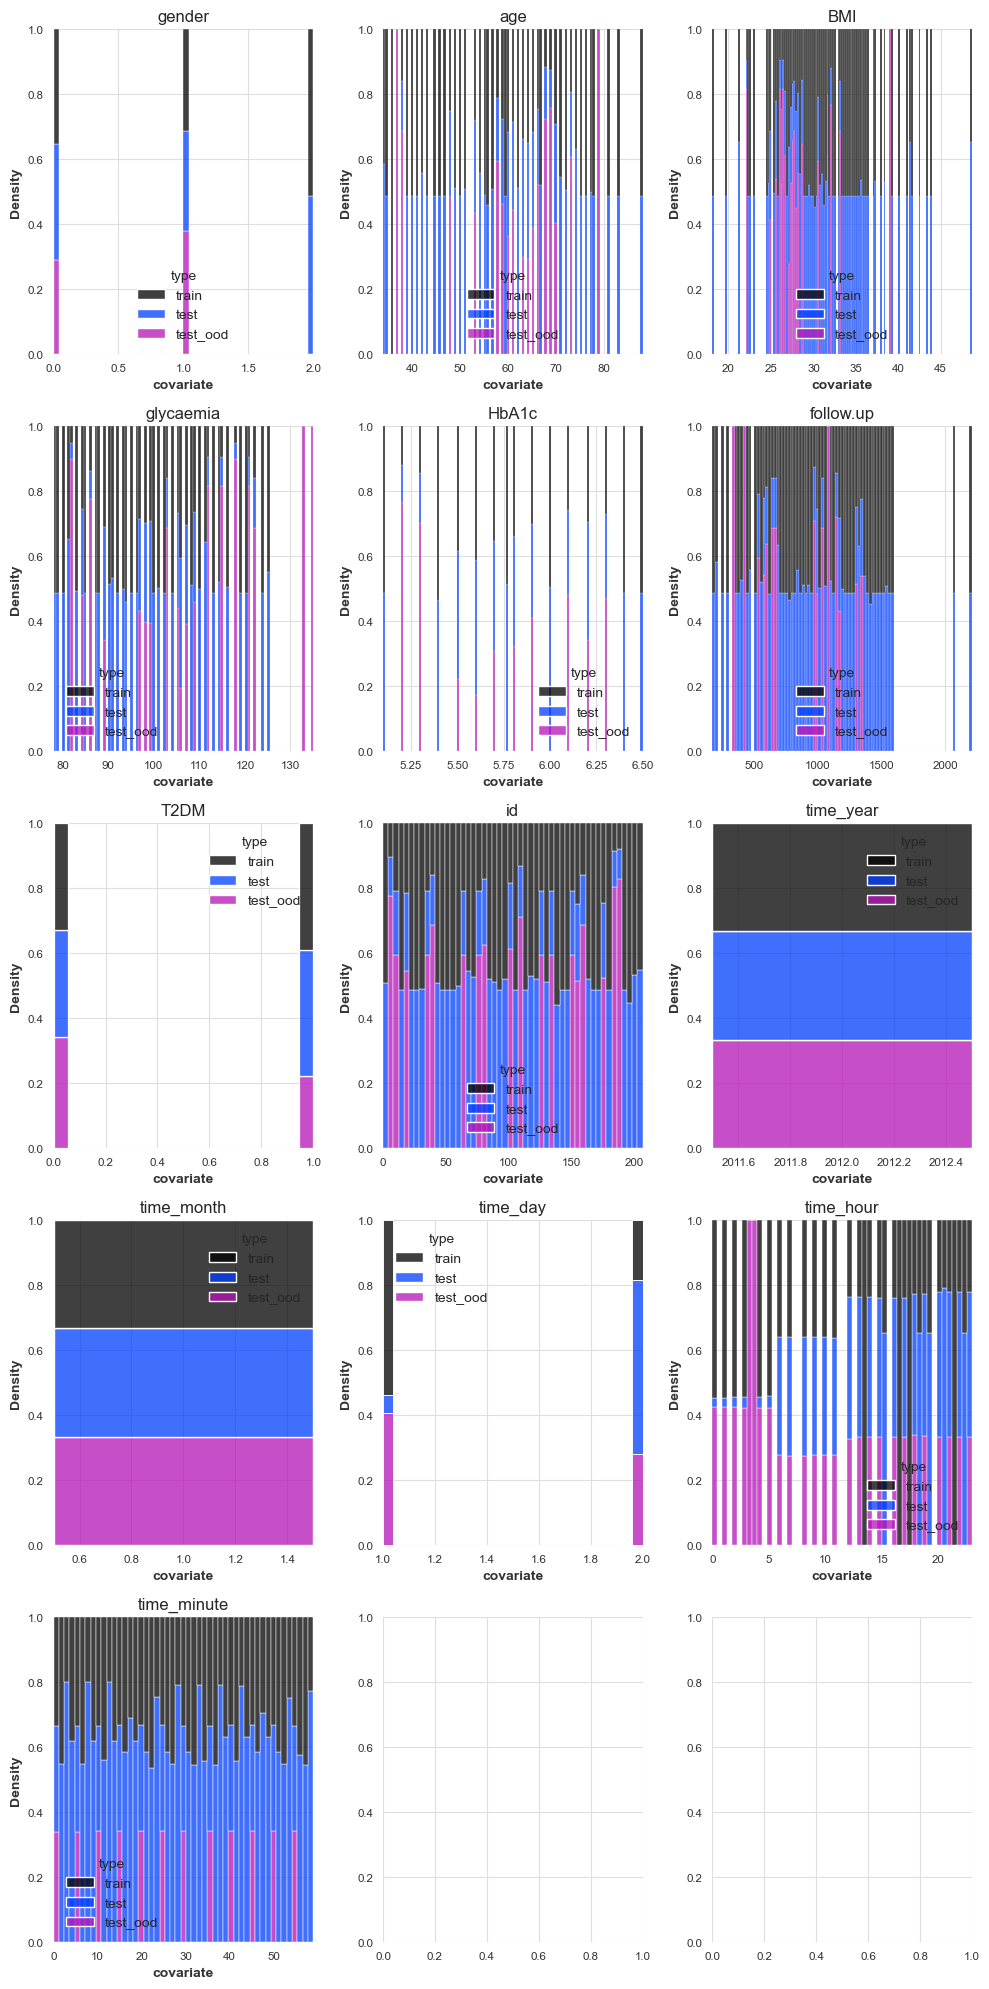

In [28]:
static_cols = formatter.get_column('static_covs')
static_cols = static_cols + [formatter.get_column('id')] if static_cols is not None else [formatter.get_column('id')]
dynamic_cols = formatter.get_column('dynamic_covs')
future_cols = formatter.get_column('future_covs')
# convert None to empty list
static_cols = [] if static_cols is None else static_cols
dynamic_cols = [] if dynamic_cols is None else dynamic_cols
future_cols = [] if future_cols is None else future_cols
# concatenate all covariates
covs = static_cols + dynamic_cols + future_cols

train_data = formatter.train_data
test_data = formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)]
test_data_ood = formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]

# plot histograms and densities of covariates using seaborn
fig, axs = plt.subplots(len(covs) // 3 + 1, 3, figsize=(10, 20))
for i, c in enumerate(covs):
    # create a dataframe with covariate and type
    df = pd.DataFrame({'covariate': train_data[c].values, 'type': 'train'})
    df2 = pd.DataFrame({'covariate': test_data[c].values, 'type': 'test'})
    df3 = pd.DataFrame({'covariate': test_data_ood[c].values, 'type': 'test_ood'})
    df = pd.concat([df, df2, df3])
    # reset index to prevent errors
    df = df.reset_index()
    # plot density
    sns.histplot(data=df, 
                 x='covariate', 
                 hue='type', 
                 ax=axs[i // 3, i % 3], 
                 stat='density', 
                 common_norm=False, 
                 common_bins=True,
                 multiple='fill')
    axs[i // 3, i % 3].set_title(c)
plt.tight_layout()


In [112]:
print(len(series['train']['future']))
print(len(series['train']['target']))

184
184


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


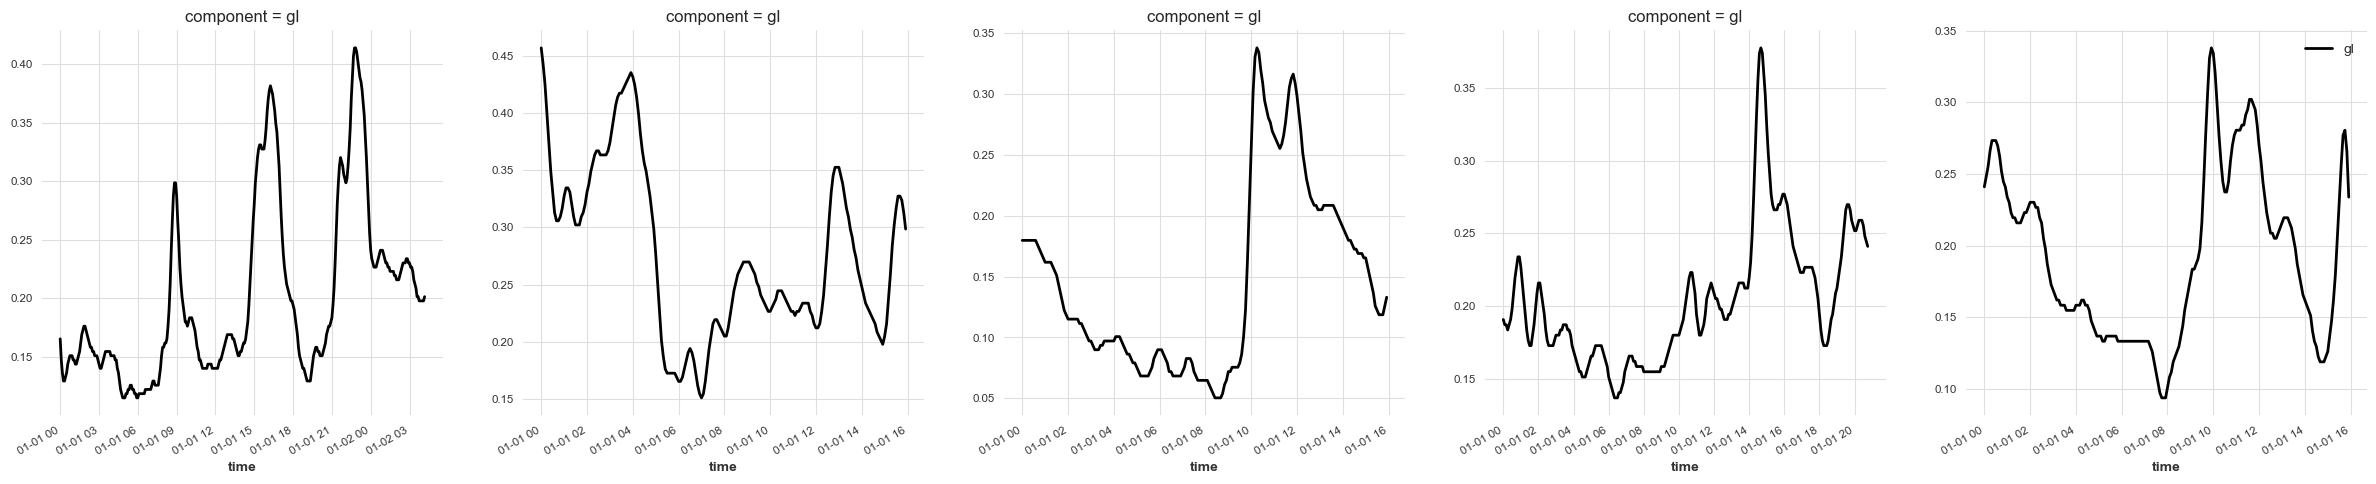

In [113]:
num_segments = 5

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i in range(5):
    series['train']['target'][i].plot(ax = axs[i])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


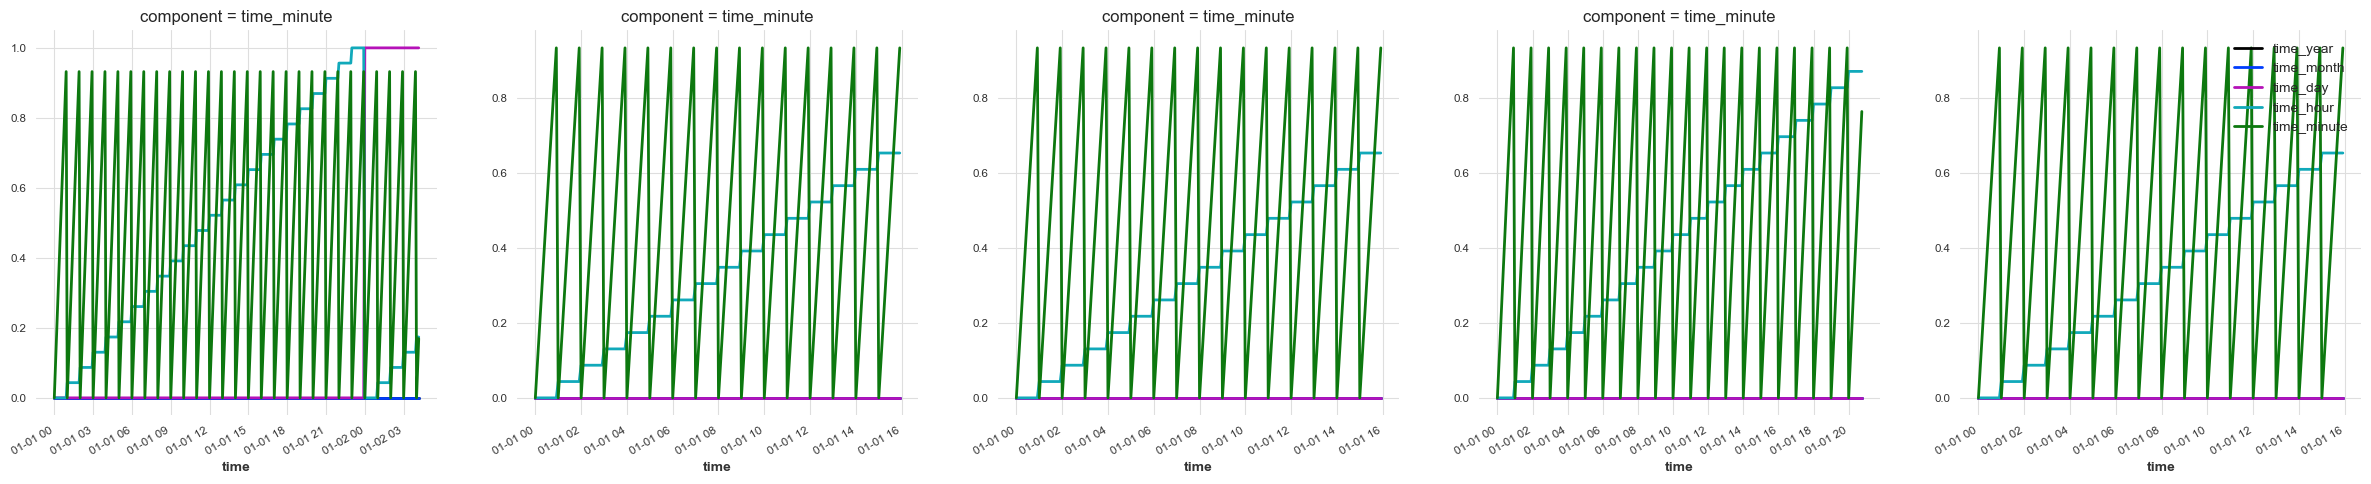

In [114]:
num_segments = 5

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i in range(5):
    series['train']['future'][i].plot(ax = axs[i])

In [3]:
# attach static covariates to series
for i in range(len(series['train']['target'])):
    static_covs = series['train']['static'][i][0].pd_dataframe()
    series['train']['target'][i] = series['train']['target'][i].with_static_covariates(static_covs)
# attach to validation and test series
for i in range(len(series['val']['target'])):
    static_covs = series['val']['static'][i][0].pd_dataframe()
    series['val']['target'][i] = series['val']['target'][i].with_static_covariates(static_covs)
for i in range(len(series['test']['target'])):
    static_covs = series['test']['static'][i][0].pd_dataframe()
    series['test']['target'][i] = series['test']['target'][i].with_static_covariates(static_covs)

In [4]:
series['train']['target'][9]

<TimeSeries (DataArray) (time: 1483, component: 1, sample: 1)>
array([[[0.4723757 ]],

       [[0.5055249 ]],

       [[0.48618788]],

       ...,

       [[0.2723757 ]],

       [[0.2812155 ]],

       [[0.29226524]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1900-01-01T13:49:00 ... 1900-01-06T17:19:00
  * component  (component) object 'gl'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates       id\ncomponent                ...
    hierarchy:          None

## Linear Regression

In [ ]:
model = models.LinearRegressionModel(lags = 60,
                                     output_chunk_length = formatter.params['length_pred'])

model.fit(series['train']['target'],
          max_samples_per_ts=100, 
          )

In [ ]:
forecasts = model.historical_forecasts(series['val']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])

In [ ]:
errors_sample = rescale_and_backtest(series['val']['target'],
                                          forecasts,  
                                          [metrics.mse, metrics.mae],
                                          scalers['target'],
                                          reduction=None)

In [ ]:
np.median(np.vstack(id_errors_sample), axis=0)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['val']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)